# Regression with PyMC3

Before jumping into cooler and more complex models, we are going to try out PyMC3 with some simple regression models. For most of these examples, non-Bayesian methods would be more than appropriate, but we need to start from some basics, so that we can learn how to use the library correctly.



In [178]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt
import seaborn as sns

import statsmodels.api as sm
#import arviz as az


x = np.linspace(0, 3, 100)
data_t = -1 + 0.5 * x + 0.1 * np.random.randn(1,len(x))
data_outliers = data_t.copy()
data_outliers[:,10] = 0
data_outliers[:,80] = -.5

## Example 1: Linear Regression

In a linear regression problem, we are trying to estimate the parameters ($\beta, \alpha$) that best describe the data ($x, y$), assuming those come from a linear approximation, and possibly a noise term $\epsilon$

$ y = \beta x + \alpha + \epsilon $

Imagine we have an instrument that measures temperature at different depths (e.g. temperatures from the surface of a material). We know that the temperature varies linearly with depth but that the slope depends on the humidity of the room. Moreover, the measurement error increases in time and the instrument needs to be replaced when the variance is above XXX . 

We would like to estimate the slope $\beta$ and bias $\alpha$ so that we could estimate the humidity, while making sure the instrument is reliable ($\epsilon$)

### Below the measurements:

[-0.5  0.   0.5  1.   1.5  2.   2.5  3.   3.5]


Text(0.5, 1.0, 'Observations')

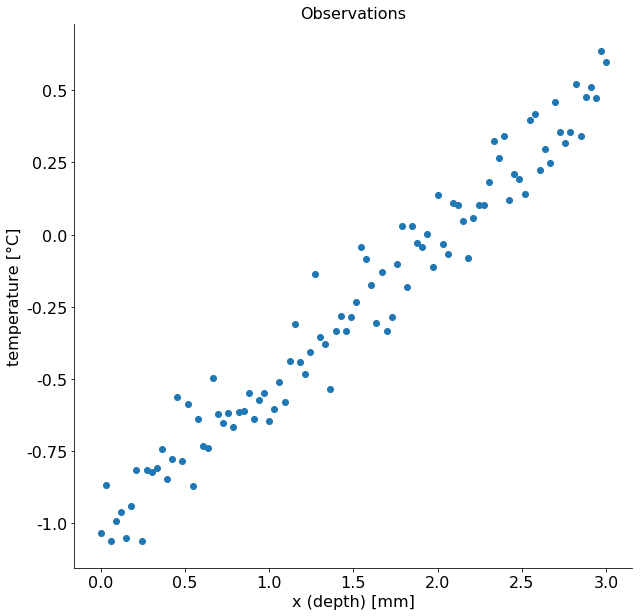

In [179]:
f,ax= plt.subplots(figsize=(10,10))
ax.scatter(x, data_t)

print(ax.get_xticks())
ax.set_xticklabels(ax.get_xticks(), fontsize = 16)
ax.set_yticklabels(ax.get_yticks(), fontsize = 16)
ax.set_xlabel('x (depth) [mm]', fontsize = 16)
ax.set_ylabel('temperature [°C]', fontsize = 16)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('Observations', fontsize= 16)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     2290.
Date:                Sat, 27 Jul 2019   Prob (F-statistic):           9.10e-70
Time:                        16:07:33   Log-Likelihood:                 96.242
No. Observations:                 100   AIC:                            -188.5
Df Residuals:                      98   BIC:                            -183.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0197      0.019    -55.019      0.0

Text(0.5, 1.0, 'Observations')

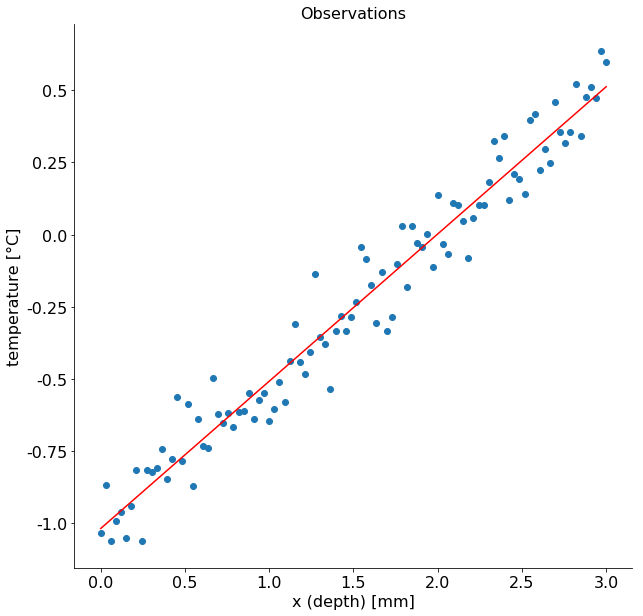

In [180]:
# Results of least square regression 


X=x[:,np.newaxis].copy()
X=sm.add_constant(X)
model = sm.OLS(data_t.T, X)
results = model.fit()
print(results.summary())

y=results.params[0]+results.params[1]*x
f,ax= plt.subplots(figsize=(10,10))
ax.scatter(x, data_t)
ax.plot(x,y, 'r')
print(ax.get_xticks())
ax.set_xticklabels(ax.get_xticks(), fontsize = 16)
ax.set_yticklabels(ax.get_yticks(), fontsize = 16)
ax.set_xlabel('x (depth) [mm]', fontsize = 16)
ax.set_ylabel('temperature [°C]', fontsize = 16)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('Observations', fontsize= 16)


As we mentioned before, for Bayesian inference we need to first make a full model described by appropriate probability distributions.

**Model**
$ y = \beta x + \alpha + \epsilon $

**Likelihood of the data**

Measures are usually normally distributed around the actual temperature values. 

$ y \sim N ( \beta x + \alpha, \epsilon ) $

**Priors of the parameters**:

  - Slope $\beta$, continuous values, $(-\inf, +\inf)$, we know it is usually between 0 and 1.
  - Bias $\alpha$, continuous values, $(-\inf, +\inf)$, the instrument we know has a bias of around $-1$
  - Variance $\epsilon$, continuous values, $(0, +\inf)$
 
$ \beta \sim N ( 0.5 , 1 ) $  
$ \alpha \sim N ( -1 , 1 ) $  
$ \epsilon \sim Gamma ( 1 , 1 ) $  

PyMC3 allows the user to specify the model in a very intuitive way. 



In [181]:
# Data
temperature = data_t
depth = x

# PyMC3 Model
with pm.Model() as model:   
    # Priors
    epsilon = pm.Gamma ('epsilon',1,1)    
    alpha = pm.Normal('alpha', -1, 1)  
    beta = pm.Normal('beta', .5, 1)  
    # Likelihood
    obs = pm.Normal("obs", mu = alpha + depth * beta, sd = np.sqrt(epsilon), observed = temperature )


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta, alpha, epsilon_log__]
100%|██████████| 6000/6000 [00:07<00:00, 798.39it/s]
/home/viola/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/viola/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/viola/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb8944eacc0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb8866bd3c8>]], dtype=object)

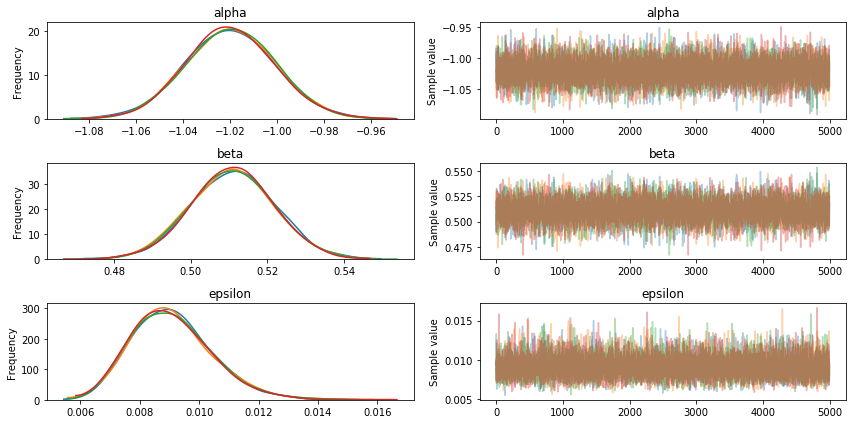

In [182]:
### Inference, by default it is a NUTS ( non-u-turn sampler) with initialisation
SAMPLES = 5000
BURNIN = 1000
with model:
    trace = pm.sample(SAMPLES, tune=BURNIN, chains=4)

# PyMC3 returns the trace of the sampler ( different backends available.)
# Built-in functions for data visualisation
pm.traceplot(trace)

In [183]:
# Descriptive statistic of the posteriors

pm.stats.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-1.019900,0.018867,0.000186,-1.057235,-0.983295,9333.058791,1.000012
beta,0.510887,0.010870,0.000116,0.489100,0.531774,8803.890159,1.000217
epsilon,0.009099,0.001345,0.000011,0.006660,0.011765,12162.525653,1.000046


In [184]:
# Check the results



Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
>Metropolis: [epsilon_log__]
100%|██████████| 10001/10001 [00:03<00:00, 2941.95it/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/viola/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


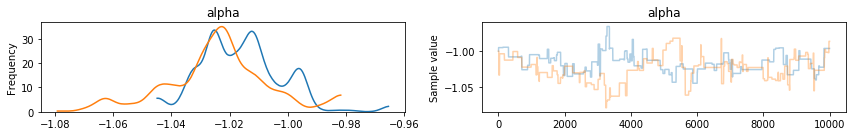

In [185]:
# What is the burnin? 

### We use now a metropolis sampler, that makes more clear what the burnin period is 
SAMPLES = 10000
with model:
    trace = pm.sample(SAMPLES, step=pm.Metropolis(), chains=2, tune = 1)

# Built-in functions for data visualisation
pm.traceplot(trace, varnames=['alpha'])

a1 = trace['alpha']

In [186]:
# What happens if the prior is less informative?
with pm.Model() as model:   
    # Priors
    epsilon = pm.Gamma ('epsilon',1,1)    
    alpha = pm.Normal('alpha', 0, 1)  
    beta = pm.Normal('beta', .5, 1)  
    # Likelihood
    obs = pm.Normal("obs", mu = alpha + depth * beta, sd = np.sqrt(epsilon), observed = temperature )


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
>Metropolis: [epsilon_log__]
100%|██████████| 10001/10001 [00:03<00:00, 2810.82it/s]
The estimated number of effective samples is smaller than 200 for some parameters.
/home/viola/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


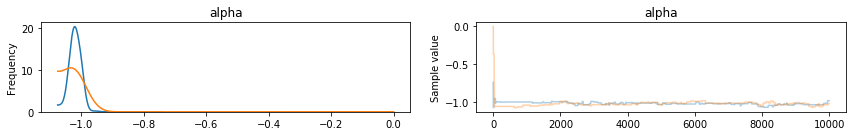

In [187]:
### We use now a metropolis sampler, that makes more clear what the burnin period is 
SAMPLES = 10000
with model:
    trace = pm.sample(SAMPLES, step=pm.Metropolis(),init=False, chains=2, tune = 1)

# Built-in functions for data visualisation
pm.traceplot(trace, varnames=['alpha'])

a2 = trace['alpha']



Text(0.5, 1.0, 'First 1000 samples , alpha = N(0,1)')

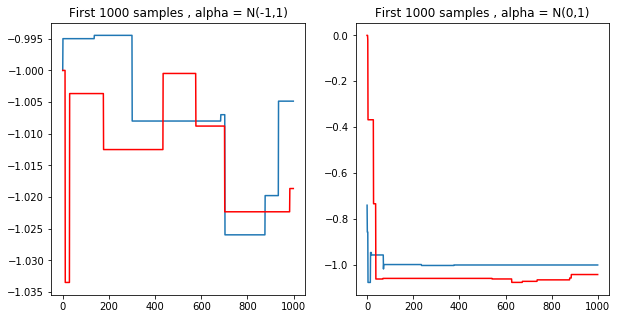

In [188]:
# Comparison of the two traces, remember we used 2 chains
f,ax = plt.subplots(1,2, figsize = (10,5))
ax[0].plot(a1[:1000])
ax[0].plot(a1[SAMPLES:SAMPLES+1000], 'r')
ax[0].set_title('First 1000 samples , alpha = N(-1,1)')
ax[1].plot(a2[:1000])
ax[1].plot(a2[SAMPLES:SAMPLES+1000], 'r')
ax[1].set_title('First 1000 samples , alpha = N(0,1)')


## Example 2: Linear Regression with Outliers

We now have some outliers in the data and we want to apply a robust regression.

For full example on outliers refer to: https://docs.pymc.io/notebooks/GLM-robust-with-outlier-detection.html

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     869.0
Date:                Sat, 27 Jul 2019   Prob (F-statistic):           1.63e-50
Time:                        16:08:01   Log-Likelihood:                 51.864
No. Observations:                 100   AIC:                            -99.73
Df Residuals:                      98   BIC:                            -94.52
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9871      0.029    -34.171      0.0

Text(0.5, 1.0, 'Observations')

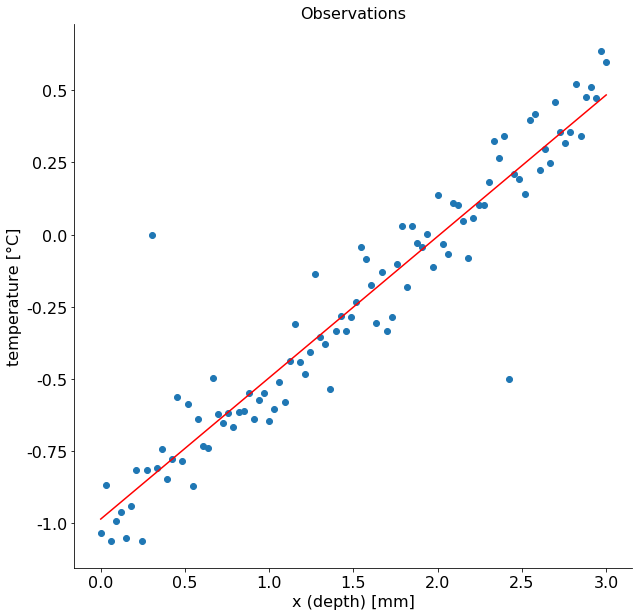

In [189]:
# Results of least square regression 


X=x[:,np.newaxis].copy()
X=sm.add_constant(X)
model = sm.OLS(data_outliers.T, X)
results = model.fit()
print(results.summary())

y=results.params[0]+results.params[1]*x
f,ax= plt.subplots(figsize=(10,10))
ax.scatter(x, data_outliers)
ax.plot(x,y, 'r')
print(ax.get_xticks())
ax.set_xticklabels(ax.get_xticks(), fontsize = 16)
ax.set_yticklabels(ax.get_yticks(), fontsize = 16)
ax.set_xlabel('x (depth) [mm]', fontsize = 16)
ax.set_ylabel('temperature [°C]', fontsize = 16)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('Observations', fontsize= 16)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta, nu_interval__, alpha, epsilon_log__]
100%|██████████| 6000/6000 [00:14<00:00, 427.41it/s]
/home/viola/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/viola/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/viola/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-1.002026,0.038832,0.000427,-1.080038,-0.928175,9421.576097,1.000043
beta,0.499298,0.022363,0.000238,0.455084,0.542854,9506.904544,0.999986
epsilon,0.036837,0.005929,0.000057,0.025864,0.048627,12256.798446,0.999934
nu,35.140117,26.056213,0.255861,4.087985,88.888024,8971.479664,0.999954


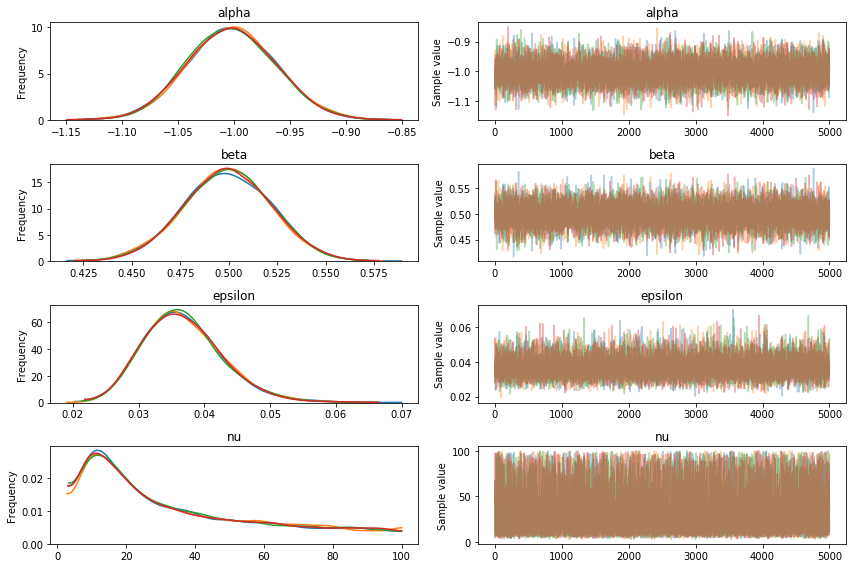

In [190]:
# Data
temperature = data_outliers
depth = x

# PyMC3 Model
with pm.Model() as model:   
    # Priors
    epsilon = pm.InverseGamma ('epsilon',1,1)    
    alpha = pm.Normal('alpha', -1, 1)  
    nu = pm.Uniform('nu', lower=1,upper = 100)
    beta = pm.Normal('beta', .5, 1)  
    #beta =  pm.StudentT('beta',nu=.5, mu=.5)
    # Likelihood
    #obs = pm.Normal("obs", mu = alpha + depth * beta, sd = np.sqrt(epsilon), observed = temperature )
    obs = pm.StudentT("obs",nu=nu, mu = alpha + depth * beta, sd = np.sqrt(epsilon),observed = temperature )

    ### Inference, by default it is a NUTS ( non-u-turn sampler) with initialisation
SAMPLES = 5000
BURNIN = 1000
with model:
    trace = pm.sample(SAMPLES, tune=BURNIN, chains=4)

# PyMC3 returns the trace of the sampler ( different backends available.)
# Built-in functions for data visualisation
pm.traceplot(trace)

# Descriptive statistic of the posteriors

pm.stats.summary(trace)

## Example 3: Non-linear Regression

Adapted from https://docs.pymc.io/notebooks/GLM-poisson-regression.html

As explained before, regression with PyMC can be applied to multiple types of data, as long as the model is coherent with the data. We try now to apply it to some temporal data, using a GLM.

We want now to regress the sneezes of an individual under antihistamine medication.

- The subject sneezes N times per day, recorded as nsneeze (int)
- The subject may or may not take an antihistamine medication during that day, recorded as the negative action nomeds (boolean)
I postulate (probably incorrectly) that sneezing occurs at some baseline rate, which increases if an antihistamine is not taken.
The data is aggregated per day, to yield a total count of sneezes on that day, with a boolean flag for antihistamine usage, with the big assumption that nsneezes have a direct causal relationship.


In [191]:
import pandas as pd
# decide poisson theta values
theta_meds = 1    # no alcohol, took an antihist
theta_nomeds = 4  # no alcohol, no antihist

# create samples
q = 1000
df = pd.DataFrame({
        'nsneeze': np.concatenate((np.random.poisson(theta_meds, q),
                                   np.random.poisson(theta_nomeds, q))),
        'nomeds': np.concatenate((np.repeat(False, q),
                                      np.repeat(True, q))) })

         nomeds
nsneeze  False     1.039
         True      3.901
dtype: float64


/home/viola/.local/lib/python3.6/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


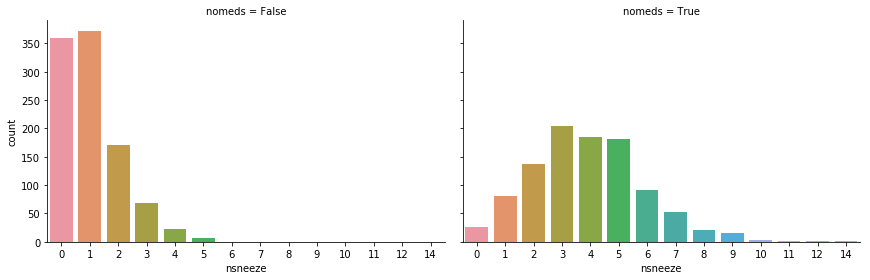

In [192]:
# Average values for nsneezes
print(df.groupby(['nomeds']).mean().unstack())

g = sns.catplot(x='nsneeze',  col='nomeds', data=df,
               kind='count', size=4, aspect=1.5)

The model we use is the following:   
    $ \theta \sim \exp \beta X$  
    $ sneezes \sim Poisson(\theta)$  
Where X is the design matrix, in this case the medication vector.

In [193]:
with pm.Model() as model:

    # define priors, weakly informative Normal
    b0 = pm.Normal('b0_intercept', mu=0, sd=10)
    b1 = pm.Normal('b1_nomeds', mu=0, sd=10)

    # define linear model and exp link function
    theta = (b0 +
            b1 * df['nomeds'])

    ## Define Poisson likelihood
    y = pm.Poisson('y', mu=np.exp(theta), observed=df['nsneeze'].values)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [b1_nomeds, b0_intercept]
100%|██████████| 6000/6000 [00:10<00:00, 584.52it/s]
The acceptance probability does not match the target. It is 0.90900507915, but should be close to 0.8. Try to increase the number of tuning steps.
/home/viola/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/viola/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
b0_intercept,0.037829,0.030659,0.000414,-0.023367,0.096876,5822.254313,1.000016
b1_nomeds,1.323281,0.034470,0.000449,1.255084,1.390395,5853.946052,1.000163


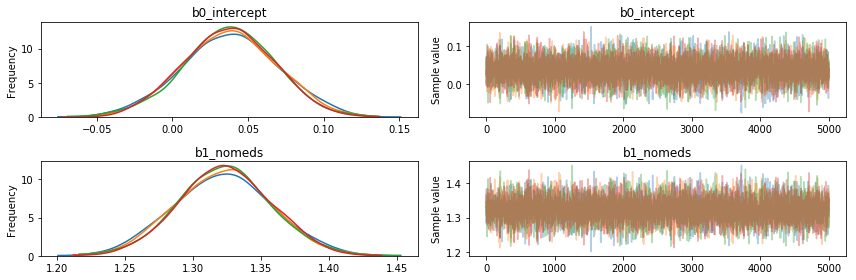

In [194]:
### Inference, by default it is a NUTS ( non-u-turn sampler) with initialisation
SAMPLES = 5000
BURNIN = 1000
with model:
    trace = pm.sample(SAMPLES, tune=BURNIN, chains=4)

# PyMC3 returns the trace of the sampler ( different backends available.)
# Built-in functions for data visualisation
pm.traceplot(trace)

# Descriptive statistic of the posteriors

pm.stats.summary(trace)

In [195]:
np.exp(pm.summary(trace)[['mean','hpd_2.5','hpd_97.5']])


,mean,hpd_2.5,hpd_97.5
b0_intercept,1.038554,0.976904,1.101723
b1_nomeds,3.755723,3.508132,4.016437
